In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import scipy.stats
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs, plot_T_x, get_conditional_mode
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj, plot_contrast_response, \
                     get_Fano, load_SSSN_variable, get_stddev_sigma
from scipy.io import loadmat
import os

In [2]:
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
basedir = "/Users/sbittner/Documents/epi/written/eLifeRevision/figures/"
figdir = os.path.join(basedir, "fig2")
figdir1 = os.path.join(basedir, "figV1_1")
figdir2 = os.path.join(basedir, "figV1_2")
figdir3 = os.path.join(basedir, "figV1_3")
figdir4 = os.path.join(basedir, "figV1_4")
#figdir = "/Users/sbittner/Documents/git_repos/dsn_talk/epi_figs/SSSN/"

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

data = loadmat(os.path.join("data", "AgosBiorxiv2.mat"))['data']

inds = [62]
dt = 0.0005
T = 200
T_plot = 250

### 1. Show fit compared to data.

(6,) (6, 1, 8)


<Figure size 180x180 with 0 Axes>

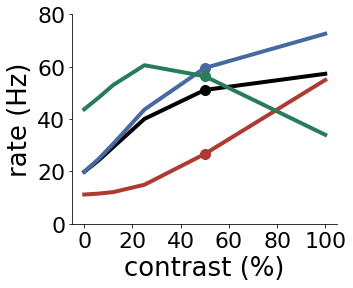

In [3]:
plt.figure(figsize=(2.5,2.5))
fontsize = 24
for ind in inds:
    W_mat = load_SSSN_variable('W', ind=ind)
    hb = load_SSSN_variable('hb', ind=ind)
    hc = load_SSSN_variable('hc', ind=ind)

    sssn_sim = SSSN_sim(0., W_mat, dt=dt, T=T_plot)

    fig, ax = plt.subplots(1,1, figsize=(5,4))
    c_points = np.array([0.5])
    hs = hb[None,:] + c_points[:,None]*hc[None,:]
    x_ss_points = sssn_sim(hs).numpy()
    plot_contrast_response(c_points, 100*x_ss_points[:,0,:], colors=colors, 
                           linestyle='o', ax=ax, fontsize=fontsize)
    
    c = np.array([0., 0.06, 0.12, 0.25, 0.5, 1.])
    hs = hb[None,:] + c[:,None]*hc[None,:]
    x_ss = sssn_sim(hs).numpy()
    print(c.shape, x_ss.shape)
    ax = plot_contrast_response(c, 100*x_ss[:,0,:], colors=colors, 
                                ax=ax, fontsize=fontsize+2)
    
    plt.tight_layout()
    ax.set_ylim([0, 80])
    ax.set_yticks([0, 20, 40, 60, 80])
    fname = os.path.join(figdir, "contrast_fit.png")
    plt.savefig(fname)

### 2. Calculate equivalence class for greater rates.  Check factor increase of k=100.

W fit
tf.Tensor(
[[ 2.1781893e+00 -1.1870320e+00 -5.9459770e-01 -2.2886373e-01]
 [ 1.6559428e+00 -6.5134937e-01 -6.7955399e-01 -2.4190041e-01]
 [ 8.9537537e-01 -5.2245674e-03 -1.5110424e-04 -7.6099437e-01]
 [ 3.3443694e+00 -2.3140862e+00 -2.5393552e-01 -2.5296208e-04]], shape=(4, 4), dtype=float32)

h fit
tf.Tensor([0.59548247 0.63011146 0.4907676  0.4861505 ], shape=(4,), dtype=float32)

W adjusted
tf.Tensor(
[[ 2.1781895e-01 -1.1870320e-01 -5.9459776e-02 -2.2886375e-02]
 [ 1.6559428e-01 -6.5134943e-02 -6.7955405e-02 -2.4190044e-02]
 [ 8.9537539e-02 -5.2245677e-04 -1.5110425e-05 -7.6099440e-02]
 [ 3.3443698e-01 -2.3140863e-01 -2.5393555e-02 -2.5296211e-05]], shape=(4, 4), dtype=float32)

h adjusted
tf.Tensor(
[[5.9548244]
 [6.3011146]
 [4.9076757]
 [4.861505 ]], shape=(4, 1), dtype=float32)


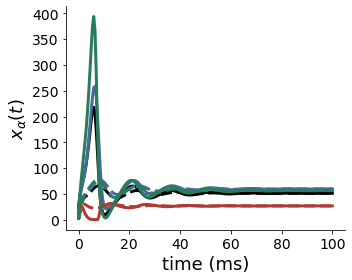

In [4]:
T_plot = 200
def get_equivalence(k, W_mat, h, n=2):
    D = W_mat.shape[0]
    A = k*tf.eye(D)
    W_mat_new = tf.matmul(tf.matmul(A, W_mat), tf.linalg.inv(A)**n)
    h_new = tf.matmul(A, h)
    return A, W_mat_new, h_new

k = 100

W_mat = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

contrast = 0.5
h = hb+contrast*hc

A_k, W_mat_k, h_k = get_equivalence(10., W_mat, h[:,None])
print('W fit')
print(W_mat)
print('\nh fit')
print(h)

print('\nW adjusted')
print(W_mat_k)
print('\nh adjusted')
print(h_k)

alphas = ['E', 'P', 'S', 'V']
fontsize=18
t = dt*np.arange(T_plot+1)

_h = h[None,:]
_h_k = h_k[None,:,0]

fig, ax = plt.subplots(1,1, figsize=(5,4))

np.random.seed(1)
sssn_sim_traj = SSSN_sim_traj(np.zeros((1,4)), W_mat, dt=dt, T=T_plot)
sssn_sim_traj_k = SSSN_sim_traj(np.zeros((1,4)), W_mat_k, dt=dt, T=T_plot)

r_t1 = np.dot(A_k**2, sssn_sim_traj(_h)[0,0,:4])
r_t2 = sssn_sim_traj_k(_h_k)[0,0,:4]
for neuron in alphas:
    j = neuron_inds[neuron]
    label_det = ''
    ax.plot(1e3*t, r_t1[j], '-', c=colors[j], 
             lw=3, label=label_det)
    ax.plot(1e3*t, r_t2[j], '--', c=colors[j], 
             lw=3, label='')
plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
ax.set_xlabel('time (ms)', fontsize=fontsize)
ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
plt.tight_layout()
plt.show()

## Plot independent simulations

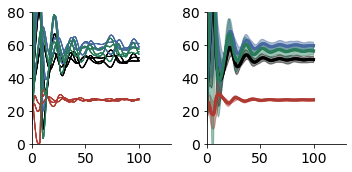

In [5]:
N_sim = 100
N_plot = 3
_h = h[None,:] * np.ones((N_sim,1))
sigma_eps = 0.5e-3*np.ones((1,4))

np.random.seed(0)
tf.random.set_seed(0)
sssn_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, dt=dt, T=T_plot)
r_t = 100.*sssn_sim_traj(_h).numpy()[:,0,:4]
mean_r_t = np.mean(r_t, axis=0)
std_r_t = np.std(r_t, axis=0)
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
for i in range(2):
    for neuron in alphas:
        j = neuron_inds[neuron]
        axs[0].plot(1e3*t, r_t[:N_plot,j,:].T, '-', c=colors[j], lw=1)
        axs[0].plot(1e3*t, r_t[:N_plot,j,:].T, '-', c=colors[j], lw=1)
        axs[1].fill_between(1e3*t, mean_r_t[j,:]-std_r_t[j,:], mean_r_t[j,:] + std_r_t[j,:], color=colors[j], alpha=0.25)
        axs[1].plot(1e3*t, mean_r_t[j,:], '-', lw=3, c=colors[j])
    axs[i].set_xlim([0, 130])
    axs[i].set_ylim([0, 80])
    plt.setp(axs[i].get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(axs[i].get_yticklabels(), fontsize=(fontsize-4))
plt.tight_layout()
fname = os.path.join(figdir, "SSSN_responses.png")
plt.savefig(fname)
plt.show()

### 3. Show the paradoxical effect.

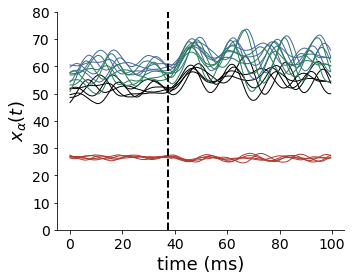

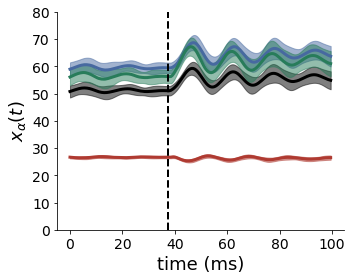

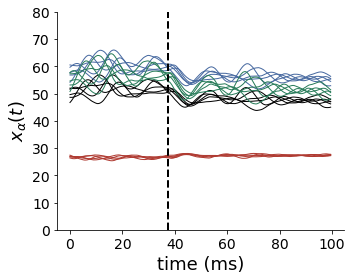

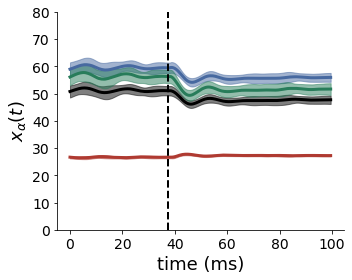

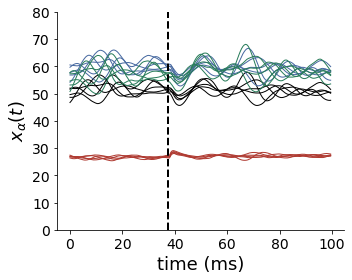

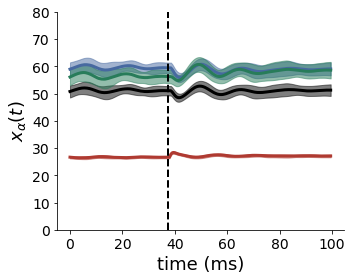

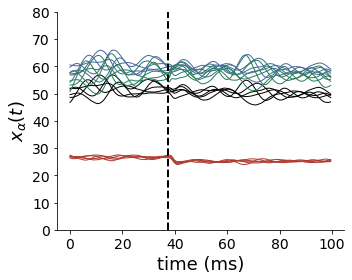

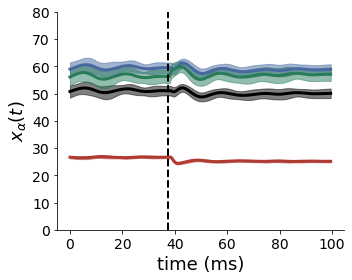

In [6]:
contrast = 0.5
alphas = ['E', 'P', 'S', 'V']
fontsize=18
ind = 62
dh_vals = [0.002, 0.002, 0.02, 0.02]
N_plot = 5
N = 50
sigma_eps = 0.5e-3*np.ones((1,4))
for dh_type, dh_val in zip(alphas, dh_vals):
    np.random.seed(0)
    tf.random.set_seed(0)
    W_mat = load_SSSN_variable('W', ind=ind)
    hb = load_SSSN_variable('hb', ind=ind)
    hc = load_SSSN_variable('hc', ind=ind)
    sssn_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=N, dt=dt, T=T_plot)
    h = (hb + contrast*hc)[None,:]
    
    r_t1 = sssn_sim_traj(h)[0,:,:4]
    
    x_init = r_t1[:,:,-1][None,:,:]
    sssn_PE_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=N, dt=dt, T=T_plot, x_init=x_init)
    
    dh = np.zeros((1,4))
    dh[0,neuron_inds[dh_type]] = dh_val
    r_t2 = sssn_PE_sim_traj(h+dh)[0,:,:4]
   
    start_ind = 125
    end_ind = 325
    r_t = tf.concat((r_t1, r_t2), axis=2).numpy()[:,:,start_ind:end_ind]
    t_stim = (T_plot-start_ind)*dt
    t = dt*np.arange(r_t.shape[2])
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    for neuron in alphas:
        j = neuron_inds[neuron]
        label_det = ''
        ax.plot(1e3*t, 100*r_t[:N_plot,j,:].T, '-', c=colors[j], 
                 lw=1, label=label_det)
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.plot([t_stim*1e3,t_stim*1e3], [0,80], 'k--')
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
    ax.set_ylim([0., 80.])
    plt.tight_layout()
    plt.savefig(os.path.join(figdir1, "sims_dh=%s.png" % dh_type))
    plt.show()
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    for neuron in alphas:
        j = neuron_inds[neuron]
        label_det = ''
        _mean = 100*np.mean(r_t[:,j,:], axis=0)
        _std = 100*np.std(r_t[:,j,:], axis=0)
        ax.fill_between(1e3*t, _mean-_std, _mean+_std, color=colors[j], alpha=0.5)
        ax.plot(1e3*t, _mean, '-', lw=3, c=colors[j])
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.plot([t_stim*1e3,t_stim*1e3], [0,80], 'k--')
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
    ax.set_ylim([0., 80.])
    plt.tight_layout()
    plt.savefig(os.path.join(figdir1, "stats_dh=%s.png" % dh_type))
    plt.show()
    

### 3.1 Load epi distribution.

In [7]:
from epi.util import get_max_H_dist
f_means = [5., 10.]
f_std = 1.
alpha = 'E'

D = 4
lb = np.zeros((D,))
ub = 0.005*np.ones((D,))
sigma_eps = Parameter("sigma_eps", D, lb=lb, ub=ub)

dists = []
for f_mean in f_means:
    name = "SSSN_stddev_sigma_%s_%.2E_%.2E_ind=%d" % (alpha, f_mean, f_std, ind)
    parameters = [sigma_eps]
    model = Model(name, parameters)
    mu = np.array([f_mean, f_std**2])

    dt = 0.0005
    T = 200
    N = 50

    stddev = get_stddev_sigma('E', W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=f_mean)
    model.set_eps(stddev)

    epi_df = model.get_epi_df()

    epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
    epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
    epi_df['elemwise_fn'] = ['affine' if 'affine' in path else 'spline' for path in epi_df['path']]
    epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
    epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
    epi_df['f_mean'] = [ep['mu'][0] for ep in epi_df['EP']]
    epi_df['f_std'] = [np.sqrt(ep['mu'][1]) for ep in epi_df['EP']]
    epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

    epi_df = epi_df[(epi_df['f_std']==f_std) & 
                    (epi_df['c0']==1e-1) & 
                    (epi_df['random_seed'] == 1)]
    

    dist, path, best_k = get_max_H_dist(model, epi_df, mu, check_last_k=1)
    print(dist, path, best_k)
    dists.append(dist)


num paths 1
path: data/epi/SSSN_stddev_sigma_E_5.00E+00_1.00E+00_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_PA_rs1/a9748e122de680ca8490cd82f190c1ea/N100_lr1.00E-03_c0=1.00E-01_gamma2.50E-01_beta2.00E+00
100 [[5. 1.]]
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


4: 0.96_0.30
best k 4
best H -23.035671
ckpt_dir data/epi/SSSN_stddev_sigma_E_5.00E+00_1.00E+00_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_PA_rs1/a9748e122de680ca8490cd82f190c1ea/N100_lr1.00E-03_c0=1.00E-01_gamma2.50E-01_beta2.00E+00
<epi.models.Distribution object at 0x7f981c91f710> data/epi/SSSN_stddev_sigma_E_5.00E+00_1.00E+00_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_PA_rs1/a9748e122de680ca8490cd82f190c1ea/N100_lr1.00E-03_c0=1.00E-01_gamma2.50E-01_beta2.00E+00 4
num paths 1
path: data/epi/SSSN_stddev_sigma_E_1.00E+01_1.00E+00_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_PA_rs1/31059e0c859c55383b1a09c0afff736a/N100_lr1.00E-03_c0=1.00E-01_gamma2.50E-01_beta2.00E+00
100 [[10.  1.]]


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


5: 0.74_0.07
best k 5
best H -23.111938
ckpt_dir data/epi/SSSN_stddev_sigma_E_1.00E+01_1.00E+00_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_PA_rs1/31059e0c859c55383b1a09c0afff736a/N100_lr1.00E-03_c0=1.00E-01_gamma2.50E-01_beta2.00E+00
<epi.models.Distribution object at 0x7f981d757240> data/epi/SSSN_stddev_sigma_E_1.00E+01_1.00E+00_ind=62/085ee8ec322138b4bc921e5396bacae3/D4_C3_affine_L2_U50_PA_rs1/31059e0c859c55383b1a09c0afff736a/N100_lr1.00E-03_c0=1.00E-01_gamma2.50E-01_beta2.00E+00 5


### 3.2 Plot epi distribution.

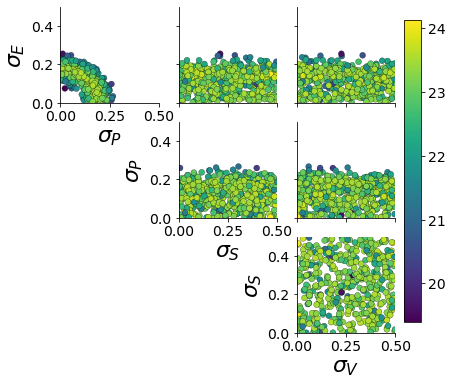

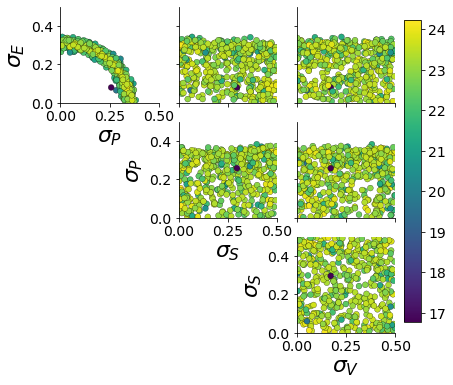

In [8]:
M = 1000
num_plot = 500
zs = []
log_q_zs = []
T_xs = []
alphas = ['E', 'P', 'S', 'V']
z_labels = [r'$\sigma_%s$' % alpha for alpha in alphas]
for i, dist in enumerate(dists):
    np.random.seed(1)
    tf.random.set_seed(1)
    z, log_q_z = dist.nf(M)
    z, log_q_z = z.numpy(), log_q_z.numpy()
    zs.append(z)
    log_q_zs.append(z)
    T_xs.append(model.eps(z).numpy())

    z_mode = z[np.argmax(log_q_z), :][None,:]

    fig = pairplot(1e2*z[:num_plot], np.arange(4), z_labels,
                   fontsize=22, figsize=(6,6), ticksize=14, s=35, c_label='', 
                   lb=lb, ub=1e2*ub, c=log_q_z[:num_plot])
    #if i==0:
    #    plt.savefig(os.path.join(figdir, "SSSN_EPI_%dHz.png" % int(f_means[i])))
    #else:
    #    plt.savefig(os.path.join(figdir2, "SSSN_EPI_%dHz.png" % int(f_means[i])))
    plt.show()

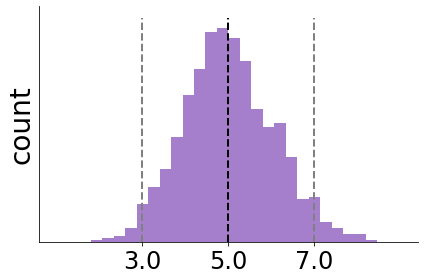

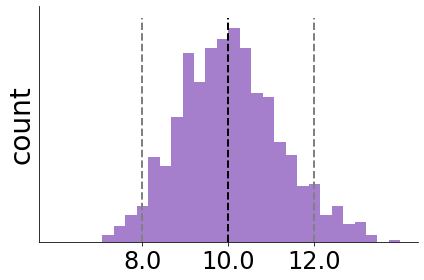

In [9]:
for f_mean, T_x in zip(f_means, T_xs):
    plot_T_x(None, T_x[:,0], bins=30, 
                 x_mean=f_mean, x_std=f_std, figsize=None,
                 xlabel='', ylim=None, fontsize=28)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "T_x_%dHz.png" % int(f_mean)), transparent=True)
    plt.show()

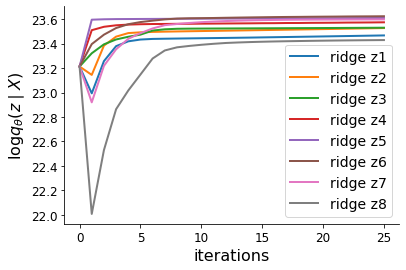

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


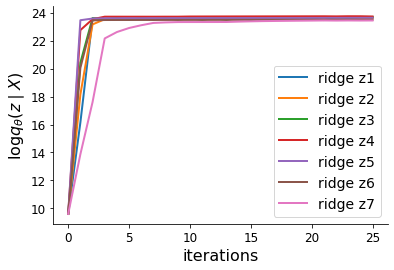

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [10]:
do_plot_opt_info = True
P_ind = neuron_inds['P']
sigma_P_res = [0.00025, 0.0005]
sigma_P_lim = [0.002, 0.0035]
res_eps = 1e-12
sigma_P_vals = []
ridge_zs = []
ridge_vs = []
for i, (dist, _sigma_P_res, _sigma_P_lim) in enumerate(zip(dists, sigma_P_res, sigma_P_lim)):
    _z, _ = dist.nf(200)
    min_P_val = np.min(_z[:,P_ind])
    max_P_val = np.max(_z[:,P_ind])
    _sigma_P_vals = np.arange((min_P_val//_sigma_P_res+1)*_sigma_P_res, 
                             min(max_P_val, _sigma_P_lim)+res_eps, _sigma_P_res)
    
    _ridge_zs = []
    log_q_zs = []
    for sigma_P_val in _sigma_P_vals:
        zs, _log_q_zs = get_conditional_mode(dist, neuron_inds['P'], sigma_P_val, 
                                            z0 = 0.0015*np.ones((4,)), lr=5.0e-8, num_steps=25)
        _ridge_zs.append(zs[-1])
        log_q_zs.append(np.array(_log_q_zs)[:,0])
    if do_plot_opt_info:
        plt.figure()
        plt.plot(np.array(log_q_zs).T)
        plt.xlabel('iterations')
        plt.ylabel(r'$\log q_\theta(z \mid X)$')
        plt.legend(["ridge z%d" % (i+1) for i in range(len(_ridge_zs))])
        plt.show()
    _ridge_zs = np.array(_ridge_zs)
    
        
    hess_z = dist.hessian(_ridge_zs)
    _ridge_vs = []
    for i, sigma_P_val in enumerate(_sigma_P_vals):
        hess_z_i = hess_z[i]
        d, v = np.linalg.eig(hess_z_i)
        min_ind = np.argmin(d)
        _v = v[:,min_ind]
        if (_v[0] < 0.):
            _v = -_v
        _ridge_vs.append(_v)
    _ridge_vs = np.array(_ridge_vs)
    
    sigma_P_vals.append(_sigma_P_vals)
    ridge_zs.append(_ridge_zs)
    ridge_vs.append(_ridge_vs)
 

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2

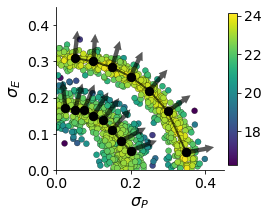

In [29]:
np.random.seed(1)
tf.random.set_seed(1)

_fontsize = 16
zs = []
ridge_color = np.array([0.,0.,0.,.65])
for i, (dist, _sigma_P_vals, _ridge_zs, _ridge_vs) in enumerate(zip(dists, sigma_P_vals, ridge_zs, ridge_vs)):
    z, log_q_z = dist.nf(M)
    z, log_q_z = z.numpy(), log_q_z.numpy()

    if i==0:
        fig, axs = pairplot(1e2*z[:num_plot], np.arange(2), z_labels,
                       fontsize=_fontsize, figsize=(3,3), ticksize=14, s=35, c_label='', 
                       lb=lb, ub=1e2*ub, c=log_q_z[:num_plot], skip_cbar=True)
    else:
        fig, axs = pairplot(1e2*z[:num_plot], np.arange(2), z_labels, subplots=(fig, axs),
                       fontsize=_fontsize, figsize=(3,3), ticksize=14, s=35, c_label='', 
                       lb=lb, ub=.9*1e2*ub, c=log_q_z[:num_plot])        

    axs.scatter(1e2*_ridge_zs[:,1], 1e2*_ridge_zs[:,0], c='k', s=70)
    axs.plot(1e2*_ridge_zs[:,1], 1e2*_ridge_zs[:,0], '-', c=ridge_color)
    fac = 0.00075
    for i, sigma_P_val in enumerate(_sigma_P_vals):
        vx = 1e2*np.array([_ridge_zs[i,1], _ridge_zs[i,1]+fac*_ridge_vs[i,1]])
        vy = 1e2*np.array([_ridge_zs[i,0], _ridge_zs[i,0]+fac*_ridge_vs[i,0]])
        axs.annotate("", xy=[vx[1], vy[1]], xytext=[vx[0], vy[0]], 
                     arrowprops=dict(headwidth=8, headlength=8, lw=.25, color=ridge_color))
    zs.append(z)
plt.savefig(os.path.join(figdir, "SSSN_EPI_both.png"))
plt.show()

0 1 -81.0483405643431 0.0


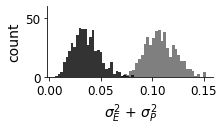

0 2 -5.859981265160157 6.283191004003056e-09


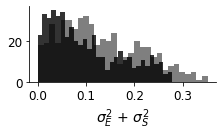

0 3 -6.248952488173992 6.110921169045626e-10


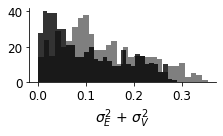

1 2 -6.605995488908255 6.411659746390623e-11


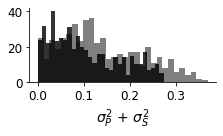

1 3 -7.245608430956859 8.604762519547908e-13


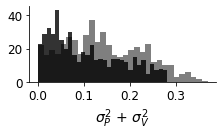

2 3 0.8384044183764441 0.4020043632278004


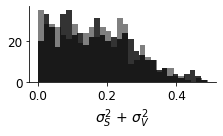

In [31]:
cs = [np.array([0., 0., 0., 0.8]), np.array([0., 0., 0., 0.5])]
_z_labels = ['$\sigma_%s^2$' % alpha for alpha in alphas]
for ii in range(4):
    for jj in range(ii+1, 4):
        np.random.seed(0)
        tf.random.set_seed(0)
        plt.figure(figsize=(3.2,2))
        fs = []
        for i, dist in enumerate(dists):
            z, log_q_z = dist.nf(num_plot)
            _z = 100.*z.numpy()
            f = _z[:,ii]**2 + _z[:,jj]**2
            fs.append(f)
            plt.hist(f, color=cs[i], bins=30)
            plt.xlabel(_z_labels[ii] + ' + ' + _z_labels[jj], fontsize=14)
        plt.tight_layout()
        
        # test for differences
        t, p = scipy.stats.ttest_ind(fs[0], fs[1]) 
        print(ii,jj,t,p)
        
        plt.tight_layout()
        plt.savefig(os.path.join(figdir2, "square_sum_%d%d" % (ii,jj)))
        if ii==0 and jj==1:
            plt.ylabel('count', fontsize=(fontsize-4))
            plt.ylim([0, 60])
            plt.tight_layout()
            plt.savefig(os.path.join(figdir, "square_sum_%d%d" % (ii,jj)))
        plt.show()

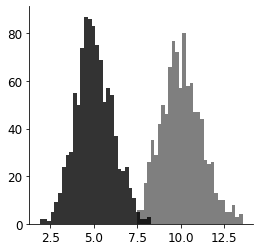

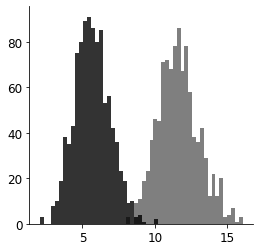

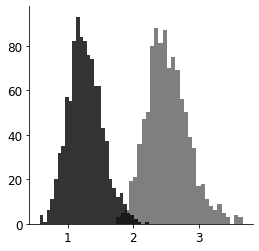

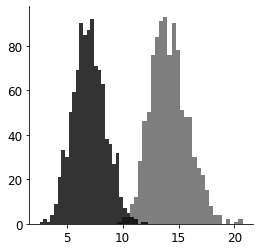

In [15]:
stddevs = []
for alpha in alphas:
    fs = []
    plt.figure(figsize=(4,4))
    _stddevs = []
    for i, z in enumerate(zs):
        stddev = get_stddev_sigma(alpha, W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=f_mean)
        f = stddev(z).numpy()[:,0]
        _stddevs.append(f)
        plt.hist(f, color=cs[i], bins=30)
    plt.show()
    stddevs.append(_stddevs)

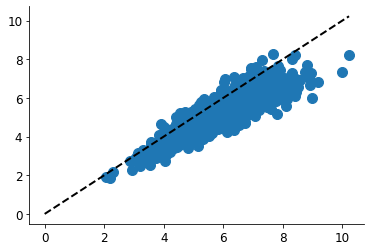

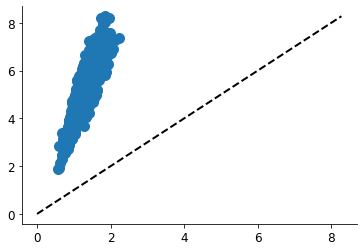

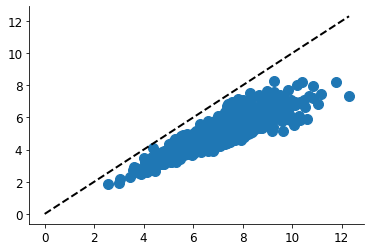

In [16]:
x = np.array([stddev[0] for stddev in stddevs]).T
for i in [1,2,3]:
    plt.figure()
    plt.scatter(x[:,i], x[:,0])
    _max = max(np.max(x[:,i]), np.max(x[:,0]))
    plt.plot([0,_max], [0, _max], 'k--')
    plt.show()

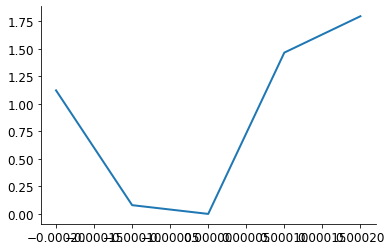

7239.816529410226 5007.267679486956


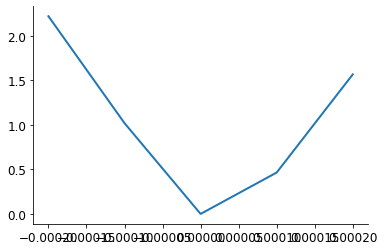

9754.947934831891 590.6002862112864


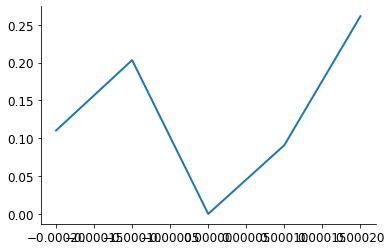

851.3586861746653 179.93416104997905


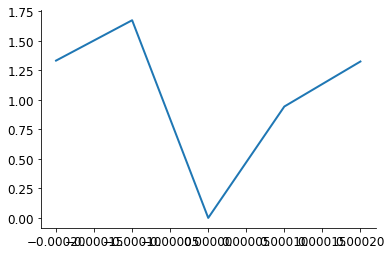

5720.441000802176 2365.527834211077


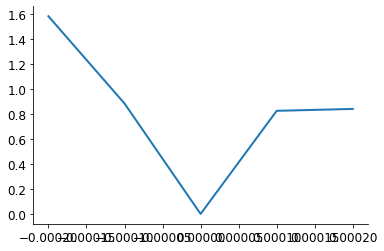

5713.353838239397 4465.208734784806


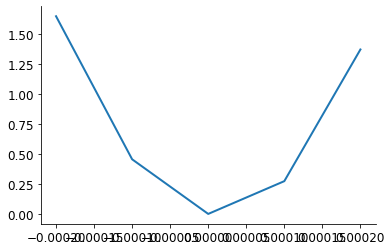

8092.910902840751 2736.98057447161


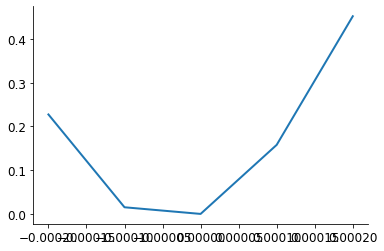

1818.164076123919 118.88078280857631


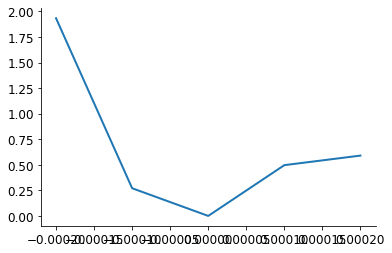

6662.581307547433 821.7893327985491


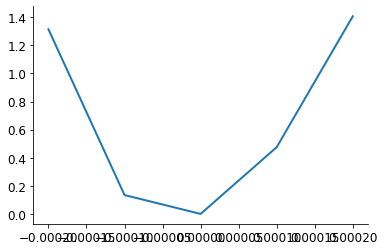

7339.302471705846 4583.075387137277


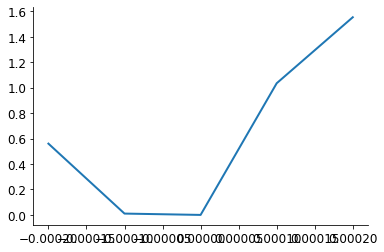

5296.93671635219 3265.8393042428147


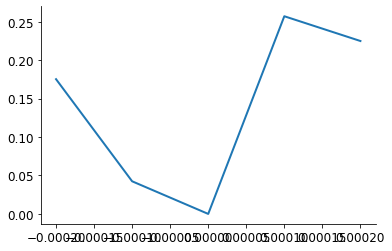

929.5364788600378 799.1739681788853


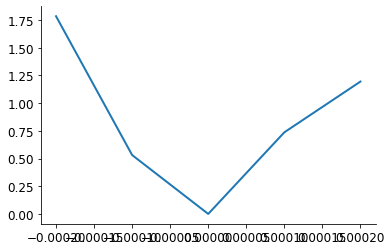

7605.627604893277 3069.790431431362


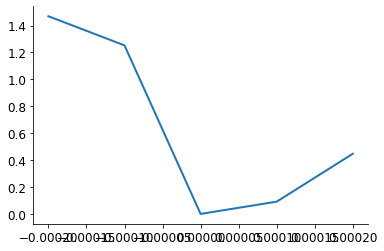

4514.946937561034 3564.4388198852535


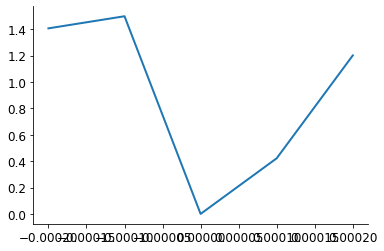

6078.166280473981 5668.000493730817


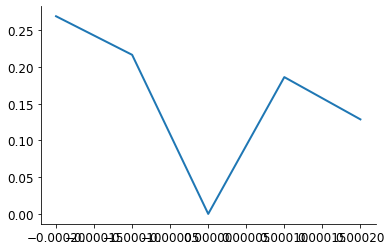

848.780700138637 397.4527972085136


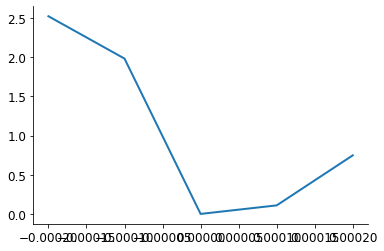

7849.809101649692 417.4327850341799


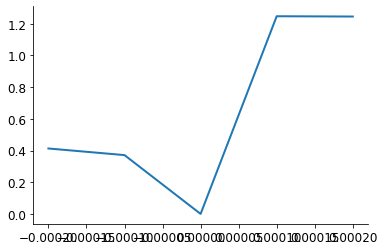

3582.5790677751816 2633.4101813180105


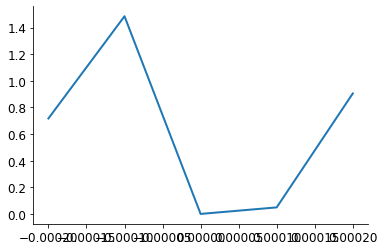

3537.8231321062362 4734.491620744978


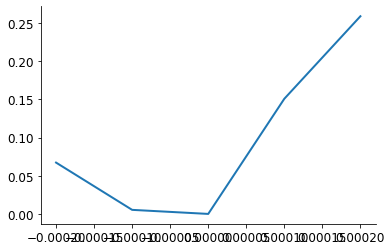

819.6297713688442 390.32663617815285


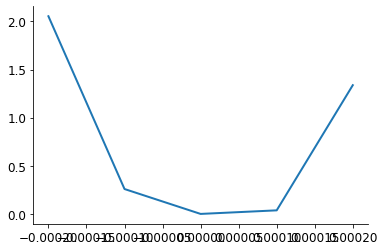

9476.303373064313 1155.768803187779


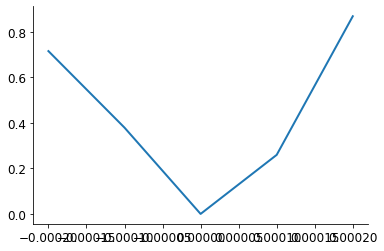

4066.579001290458 2193.139621189662


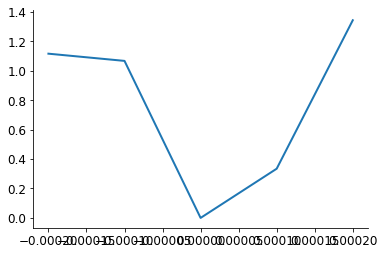

6022.0909118652335 5819.9773515973775


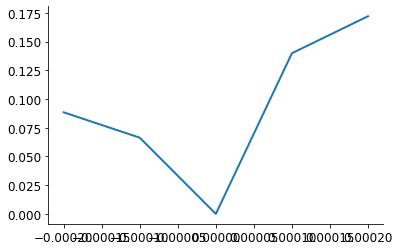

596.7545509338379 120.47358921595982


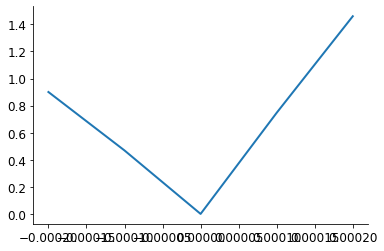

5876.846313476562 1531.7385537283762


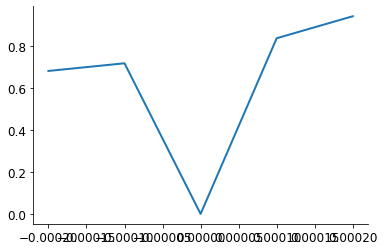

3529.387201581683 1518.935476030622


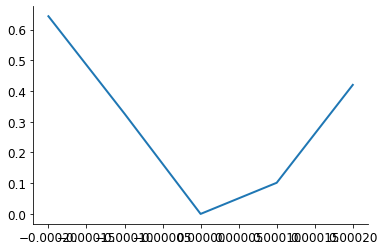

2733.2912172589986 5811.32207598005


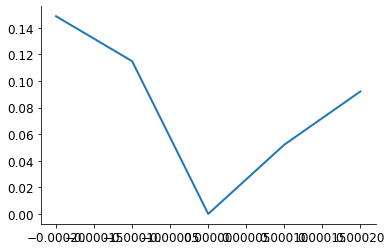

568.8514028276717 194.0453052520752


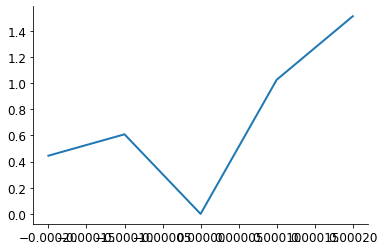

4424.685069492885 1418.4611184256416


In [17]:
dist_ind = 1
def sensitivity(facs, d):
    m, b, r, p, _ = scipy.stats.linregress(facs, d)
    return m, r

def rvs(D, N):
    v = np.random.normal(0., 1., (N,D))
    v = v / np.linalg.norm(v, axis=1)[:,None]
    return v

fac_lim = 0.0002
n_rand = 20
v_rands = rvs(4, n_rand)
ms = []
rs = []
sens_samps = 5
facs = np.linspace(-fac_lim, fac_lim, sens_samps)
stddev_f = get_stddev_sigma('all', W_mat, h, N=5*N, dt=dt, T=400, T_ss=200, mu=f_mean)

alphas = ['E', 'P', 'S', 'V']
m_rands = []
r_rands = []
for i, sigma_P_val in enumerate(sigma_P_vals[dist_ind]):
    z_i = ridge_zs[dist_ind][i][None]
    v_i = ridge_vs[dist_ind][i][None]
    z_perturb = z_i + facs[:,None]*v_i
    T_x_perturb = stddev_f(z_perturb)
    _m_rands = []
    _r_rands = []
    for j, alpha in enumerate(alphas):
        alpha_ind = neuron_inds[alpha]
        d = np.abs(T_x_perturb[:,alpha_ind]-T_x_perturb[(sens_samps//2),alpha_ind])
        plt.figure()
        plt.plot(facs, d)
        plt.show()
        _m, _r = sensitivity(np.abs(facs), d)
        ms.append(_m)
        rs.append(_r)
        # j vector
        v_j = np.zeros((1,4))
        v_j[0,alpha_ind] = 1.
        z_j_perturb = z_i + facs[:,None]*v_j
        T_x_j_perturb = stddev_f(z_j_perturb)
        d = np.abs(T_x_j_perturb[:,alpha_ind]-T_x_j_perturb[(sens_samps//2),alpha_ind])
        m2, r2 = sensitivity(np.abs(facs), d)
        print(_m, m2)
        
        _sens_rand = []
        for k in range(n_rand):
            print('x %d: %s %d/%d \r' % (i+1, alpha, k+1, n_rand), end="")
            z_perturb = z_i + facs[:,None]*v_rands[k,:][None,:]
            T_x_perturb = stddev_f(z_perturb)
            d = np.abs(T_x_perturb[:,alpha_ind]-T_x_perturb[(sens_samps//2),alpha_ind])
            _sens_rand.append(sensitivity(np.abs(facs), d))
        _m_rands.append(np.array([_sens_rand[j][0] for j in range(n_rand)]))
        _r_rands.append(np.array([_sens_rand[j][1] for j in range(n_rand)]))
    m_rands.append(_m_rands)
    r_rands.append(_r_rands)
m_rands = np.array(m_rands)
r_rands = np.array(r_rands)

In [163]:
dfs = []
for i, sigma_P_val in enumerate(sigma_P_vals[dist_ind]):
    for j, alpha in enumerate(alphas):
        dfs.append(pd.DataFrame({'alpha':alpha, 'sigma_P_val':100.*sigma_P_val, 'type':'rand', 'm':m_rands[i][j]/100.}))
df = pd.concat(dfs)

(7,)


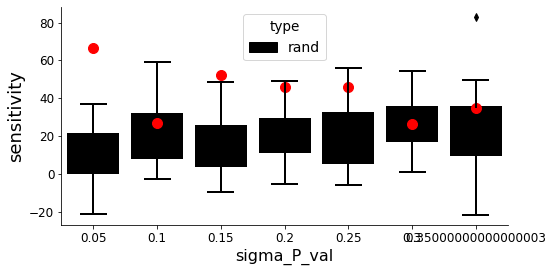

(7,)


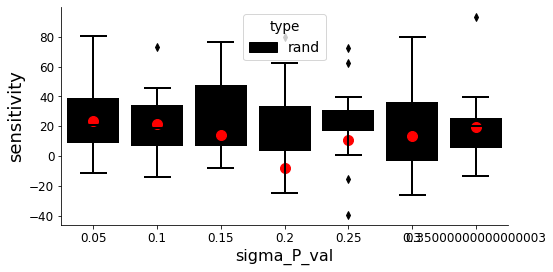

(7,)


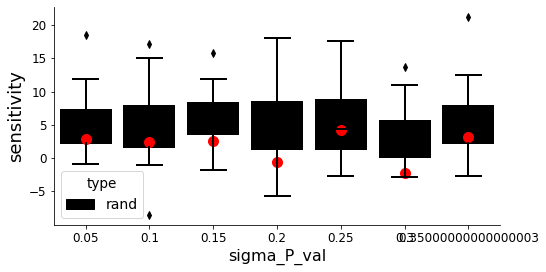

(7,)


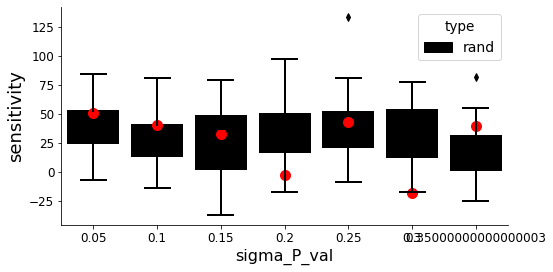

'plt.figure(figsize=(6,3))\nax = sns.boxplot(data=df, x=\'sigma_P_val\', y=\'m\', hue=\'alpha\')\nax.set_xlabel(r\'$\\sigma_P$\', fontsize=24)\nax.set_ylabel(\'sensitivity\', fontsize=24)\nax.scatter(range(len(sigma_P_vals)), np.array(ms)/100., c=\'k\')\nax.get_legend().remove()\nxticks = [0,2,4,6,8,10]\nax.set_xticks(xticks)\nxticklabels = ["%.3f" % (100*sigma_P_vals[tick]) for tick in xticks]\nax.set_xticklabels(xticklabels)\nplt.show()'

In [164]:
num_sigma_P_vals = len(sigma_P_vals[dist_ind])
for i, alpha in enumerate(alphas):
    _ms = [ms[_ind] for _ind in range(i,len(alphas)*num_sigma_P_vals, len(alphas))]
    _m = np.array(_ms) / 100.
    print(_m.shape)
    _df = df[df['alpha']==alpha]
    plt.figure(figsize=(8,4))
    ax = sns.boxplot(data=_df, x='sigma_P_val', y='m', hue='type', palette=colors)
    ax.scatter(range(num_sigma_P_vals), _m, c='r')
    ax.set_ylabel('sensitivity', fontsize=18)
    plt.show()

"""plt.figure(figsize=(6,3))
ax = sns.boxplot(data=df, x='sigma_P_val', y='m', hue='alpha')
ax.set_xlabel(r'$\sigma_P$', fontsize=24)
ax.set_ylabel('sensitivity', fontsize=24)
ax.scatter(range(len(sigma_P_vals)), np.array(ms)/100., c='k')
ax.get_legend().remove()
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
xticklabels = ["%.3f" % (100*sigma_P_vals[tick]) for tick in xticks]
ax.set_xticklabels(xticklabels)
plt.show()"""

In [65]:
"""Fano_extra = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=300, T_ss=150, mu=ff_mean)
model.set_eps(Fano_extra)

T_x = model.eps(z).numpy()
plot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,
             x_mean=ff_mean, x_std=ff_std, figsize=None,
             xlabel=r'$F(x; z)$', ylim=None, fontsize=28)"""

"Fano_extra = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=300, T_ss=150, mu=ff_mean)\nmodel.set_eps(Fano_extra)\n\nT_x = model.eps(z).numpy()\nplot_T_x(None, T_x[:,0], bins=30, xmin=.5, xmax=1.5,\n             x_mean=ff_mean, x_std=ff_std, figsize=None,\n             xlabel=r'$F(x; z)$', ylim=None, fontsize=28)"

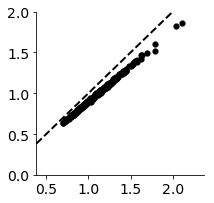

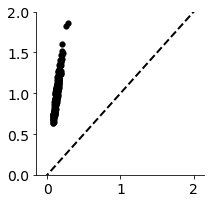

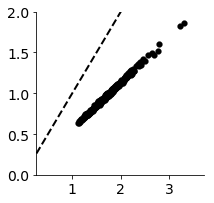

In [74]:
Fano_all = get_Fano_sigma('all', W_mat, h, N=N, dt=dt, T=T, T_ss=T-50, mu=ff_mean)
fano_all = Fano_all(z).numpy()

fano_labels = [r'$F_%s$' % alpha for alpha in alphas]
inhib_types = ['P', 'S', 'V']
for alpha in inhib_types:
    alpha_ind = neuron_inds[alpha]
    fano_E_alpha = np.stack((fano_all[:,0], fano_all[:,alpha_ind]), axis=1)
    fig, ax = pairplot(fano_E_alpha, np.arange(2), ['', ''],
                   fontsize=24, figsize=(3,3), ticksize=14, s=35,
                   lb=np.zeros(2,), ub=3.*np.ones((2,)), unity_line=True)
    ax.set_ylim([0., 2.])
    #plt.savefig(os.path.join(figdir, "Fig3", "PanelF_E%s.png" % alpha))
    plt.show()

In [90]:
#sigma_eps = np.array([[2.7747380e-02, 2.9908607e-02,  1.0897118e-03, 1.3312697e-05]])
sigma_eps = np.array([[0.00175, 0.00175, 0.002, 0.002]])

_c = np.linspace(0, 1, 25)

_N = 5
hs = hb[None,:] + _c[:,None]*hc[None,:]
F_means = []
F_stds = []
for m in range(200):
    sigma_eps = z[m,:][None,:]
    Fano = get_Fano('all', sigma_eps, W_mat, dt=dt, N=N, T=T)
    Fs = []
    for k in range(_N):
        print('m=%d: %2d/%2d \r' % (m+1, k+1, _N), end="")
        Fs.append(Fano(hs).numpy())
    Fs = np.array(Fs)
    F_means.append(np.mean(Fs, axis=0))
    F_stds.append(np.std(Fs, axis=0))

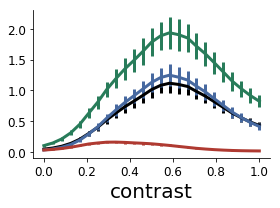

In [91]:
F_means = np.array(F_means)
F_stds = np.array(F_stds)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
fontsize= 20
for ii in range(4):
    ax.errorbar(_c, np.mean(F_means[:,:,ii], axis=0), 
                np.std(F_means[:,:,ii], axis=0), c=colors[ii], lw=3)
ax.set_xlabel('contrast', fontsize=fontsize)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "Fig3", "PanelG.png"))
plt.show()

F_mean (10, 8)
F_std (10, 8)


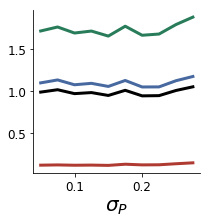

In [14]:
Ns = [50]
Ts = [150]
F_means = {}
F_stds = {}
_N = 50
for N in Ns:
    for T in Ts:
        Fano = get_Fano_sigma('all', W_mat, h, dt=dt, N=N, T=T)
        sigma_eps = ridge_zs
        Fs = []
        for k in range(_N):
            print('%2d/%2d \r' % (k+1, _N), end="")
            Fs.append(Fano(sigma_eps).numpy())
        Fs = np.array(Fs)
        F_means.update({(N,T): np.mean(Fs, axis=0)})
        F_stds.update({(N,T): np.std(Fs, axis=0)})

fig, axs = plt.subplots(len(Ns), len(Ts), figsize=(3,3))
fontsize= 20
for i, N in enumerate(Ns):
    for j, T in enumerate(Ts):
        if len(Ns) == 1:
            if len(Ts) == 1:
                ax = axs
            else:
                ax = axs[j]
        elif len(Ts) == 1:
            ax = axs[i]
        else:
            ax = axs[i,j]
        F_mean = F_means[(N,T)]
        F_std = F_stds[(N,T)]
        print('F_mean', F_mean.shape)
        print('F_std', F_std.shape)
        for ii in range(4):
            #plt.errorbar(_c, h_var[:,i], h_var[:,i+4], c=colors[i])
            #ax.errorbar(np.arange(5), F_mean[:,ii], F_std[:,ii], c=colors[ii])
            ax.plot(1e2*sigma_P_vals, F_mean[:,ii], c=colors[ii], lw=3)
            #plt.plot(_c, h_var[:,i], c=colors[i])
        if (i==(len(Ns)-1)):
            ax.set_xlabel(r'$\sigma_P$', fontsize=fontsize)
        #if (j==0):
            #ax.set_ylabel(r'$F(x; z)$', fontsize=fontsize)
        #ax.set_ylim([0, 0.05])
plt.show()


0.05345521893470395
198.12273 202.37111 0.33196604


(0, 0.003)

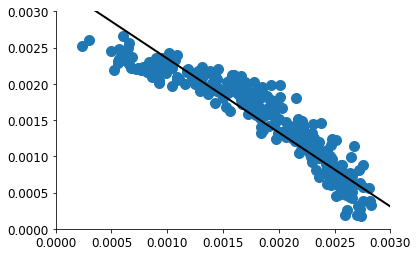

In [110]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(z[:,:2], T_x[:,0])
print(linreg.score(z[:,:2], T_x[:,0]))
a, b = linreg.coef_
c = linreg.intercept_
print(a,b,c)
x2 = np.linspace(0., 0.003, 7)
x1 = (1./a)*(-b*x2 - c + 1)
plt.figure()
plt.scatter(z[:,1], z[:,0])
plt.plot(x2, x1, 'k')
plt.xlim([0,.003])
plt.ylim([0,.003])

In [125]:
fano = get_Fano_sigma(alpha, W_mat, h, N=N, dt=dt, T=1000, T_ss=500, mu=ff_mean)
model.set_eps(fano)
T_x2 = model.eps(z)

0.2013501684955349
183393.33 152147.11 -0.06324375


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


(0, 0.003)

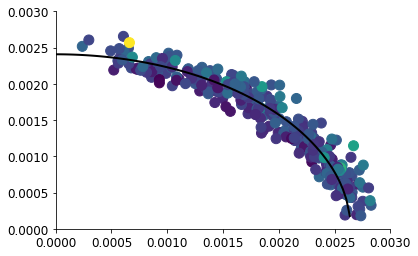

In [129]:
linreg = LinearRegression().fit(z[:,:2]**2, T_x[:,0])

print(linreg.score(z[:,:2]**2, T_x[:,0]))
a, b = linreg.coef_
c = linreg.intercept_
print(a,b,c)
x2 = np.linspace(0., 0.003, 100)
x1 = np.sqrt((1./a)*(-b*(x2**2) - c + 1.))
plt.figure()
plt.scatter(z[:,1], z[:,0], c=T_x[:,0])
plt.plot(x2, x1, 'k')
plt.xlim([0,.003])
plt.ylim([0,.003])

In [103]:
print(z)

[[0.0022198  0.00067846 0.00109395 0.00203018]
 [0.00212478 0.00130113 0.00465937 0.00251583]
 [0.0019276  0.00171507 0.00411682 0.00083306]
 ...
 [0.00200281 0.00116387 0.00074885 0.00303661]
 [0.00233102 0.0005979  0.00219432 0.00189279]
 [0.00194572 0.00145315 0.00206235 0.00164582]]
